In [1]:
import altair as alt

from traffic.core import Traffic
from traffic.core.projection import EuroPP

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP

import warnings
warnings.filterwarnings("ignore")

# Preliminary test

In [5]:
original_traffic = Traffic.from_file("../deep_traffic_generation/data/traffic_162-216_noga_tilFAF.pkl")
original_traffic = original_traffic.simplify(altitude = "altitude", tolerance = 1e3).eval(desc = "", max_workers = 20)
original_traffic

  0%|          | 0/4414 [00:00<?, ?it/s]

,count
flight_id,
SWR819_3796,32
SWR77E_3755,31
SWR1271_2680,30
SWR101R_1854,30
SWR134J_2891,30
SWR77E_3744,30
SWR75B_3664,30
SWR81C_3836,29
SWR1349_2844,29


<AxesSubplot:>

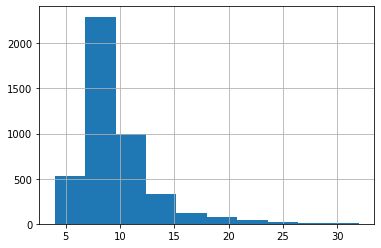

In [13]:
count = original_traffic.data.groupby("flight_id").timestamp.count()
count.hist()

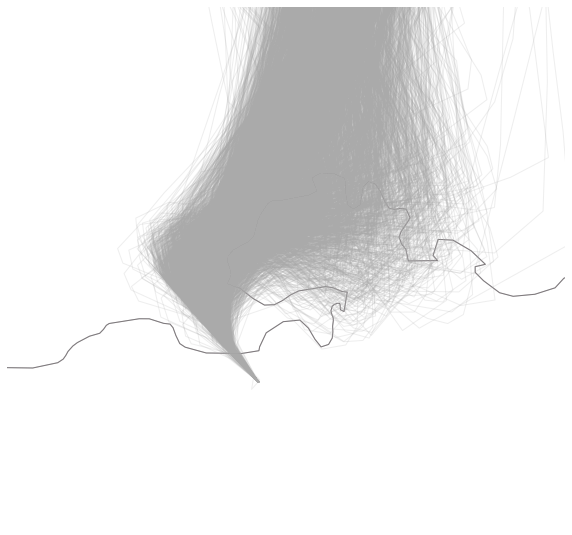

In [26]:
import matplotlib.pyplot as plt
from traffic.core.projection import CH1903p, EuroPP
from traffic.drawing import countries

flt = count[count < 12].index

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure
    ax.set_extent((8, 9, 47.37, 48))
    original_traffic[flt].plot(ax, alpha=0.2)

In [40]:
#Douglas-Peucker

traffic = Traffic.from_file("../deep_traffic_generation/data/traffic_162-216.pkl")

simplified_t = (
    traffic
    .simplify(tolerance=1e3)
    .eval(desc="")
)
simplified_t

  0%|          | 0/4437 [00:00<?, ?it/s]

,count
flight_id,
EWG7ME_5129,31
SWR819_17004,30
SWR75B_16466,30
SWR1349_9689,29
SWR77E_16704,28
SWR134J_9740,28
SWR169A_11166,27
SWR109D_8470,25
SWR1189_8955,25


In [41]:
simplified_t.to_pickle("../deep_traffic_generation/data/traffic_162-216_dp.pkl")

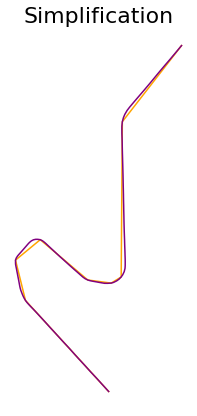

In [9]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=EuroPP()))
    simplified_t[0].plot(ax, c="orange", label="Douglas-Peucker")
    traffic[0].plot(ax, c="purple", label="original")
    ax.set_title("Simplification")

    plt.show()

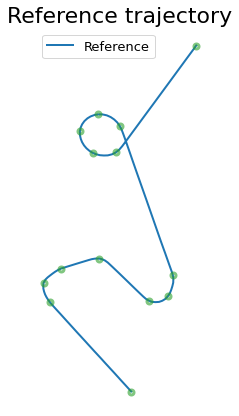

In [15]:
i = np.random.randint(len(traffic))

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.set_title("Reference trajectory")
    traffic[i].plot(ax, c="tab:blue", lw=2.0, label="Reference")
    # Douglas-Peucker
    simplified_t[i].plot(ax, mec="tab:green",mew=3.0,ms=10.0, mfc="none", marker=".", ls="", alpha=0.6)
    ax.legend(loc=0)

# Test Inputs NN

In [3]:
original_traffic = Traffic.from_file("../../deep_traffic_generation/data/traffic_noga_tilFAF_train_simplified_zeroed.pkl")
original_traffic

,count
flight_id,
2FPLF_000,105
SWR2277_9616,105
SWR2277_9605,105
SWR2277_9606,105
SWR2277_9607,105
SWR2277_9608,105
SWR2277_9609,105
SWR2277_9610,105
SWR2277_9611,105


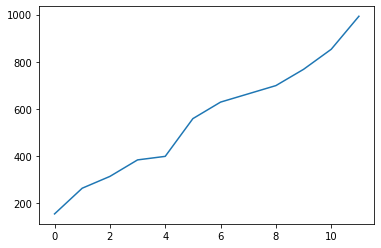

In [33]:
# The non relevant part of the trajectory is defined by a slow increase in timedelta
a = original_traffic[0].data.timedelta.diff(1) > 10
plt.plot(original_traffic[0].data.timedelta.values[a])

In [37]:
from deep_traffic_generation.core.datasets import TrafficDataset
from sklearn.preprocessing import MinMaxScaler

dataset = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train_simplified_zeroed.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

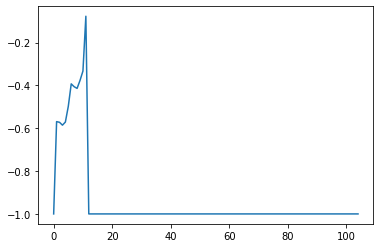

In [44]:
plt.plot(dataset.data[30,3,:].numpy())

In [54]:
from traffic.algorithms.generation import Generation
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

#Simulate out data
features = ["track", "groundspeed", "altitude", "timedelta"]
X = np.stack(list(f.data[features].values.ravel() for f in original_traffic))

#Have to do some generation to have access to build traffic
g2 = original_traffic.generation(
    generation=GaussianMixture(n_components=1),
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1, 1))
)

out_traf = g2.build_traffic(X, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

In [61]:
out_traf[10].data

,track,groundspeed,altitude,timedelta,flight_id,callsign,icao24,timestamp,latitude,longitude
1050525,120.17052,384.021803,14475.0,0.0,TRAJ_10005,TRAJ_10005,TRAJ_10005,2022-03-31 09:55:06+00:00,47.796444,7.915949
1050526,121.834206,248.358397,4450.0,308.0,TRAJ_10005,TRAJ_10005,TRAJ_10005,2022-03-31 10:00:14+00:00,47.612472,8.357743
1050527,137.29061,159.226117,3300.0,431.0,TRAJ_10005,TRAJ_10005,TRAJ_10005,2022-03-31 10:02:17+00:00,47.546585,8.447731
1050528,0,0,0,0,TRAJ_10005,TRAJ_10005,TRAJ_10005,2022-03-31 09:55:06+00:00,47.546585,8.447731
1050529,0,0,0,0,TRAJ_10005,TRAJ_10005,TRAJ_10005,2022-03-31 09:55:06+00:00,47.546585,8.447731
...,...,...,...,...,...,...,...,...,...,...
1050625,0,0,0,0,TRAJ_10005,TRAJ_10005,TRAJ_10005,2022-03-31 09:55:06+00:00,47.546585,8.447731
1050626,0,0,0,0,TRAJ_10005,TRAJ_10005,TRAJ_10005,2022-03-31 09:55:06+00:00,47.546585,8.447731
1050627,0,0,0,0,TRAJ_10005,TRAJ_10005,TRAJ_10005,2022-03-31 09:55:06+00:00,47.546585,8.447731
1050628,0,0,0,0,TRAJ_10005,TRAJ_10005,TRAJ_10005,2022-03-31 09:55:06+00:00,47.546585,8.447731


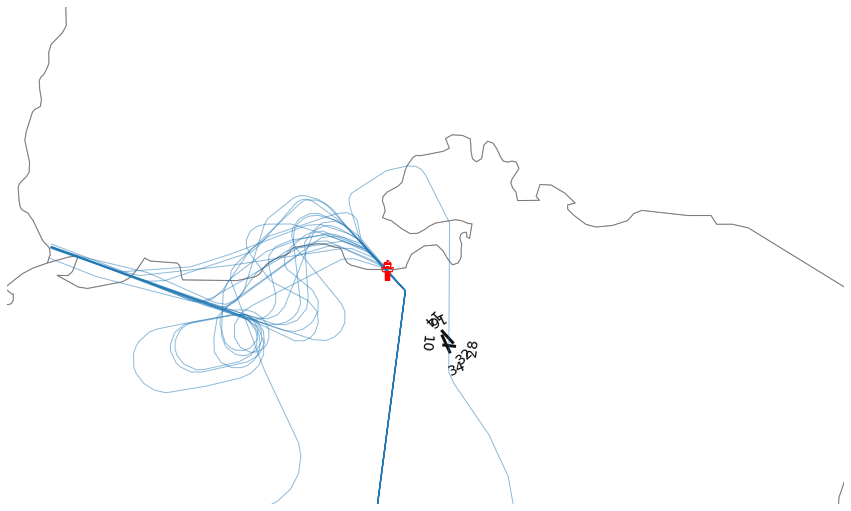

In [14]:
from traffic.core.projection import EuroPP
from traffic.drawing import countries
from traffic.data import airports
from traffic.drawing.markers import atc_tower
import cartopy.crs as ccrs


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())

    ax.set_extent((7.5, 9.5, 47.2, 48))
    # ax.set_global()

    original_traffic[:20].plot(ax, alpha=0.5, color = "#1f77b4")

    # airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=True,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )

    lon, lat = 8.40241667, 47.57969444
    projx, projy = ax.projection.transform_point(lon, lat, ccrs.Geodetic())

    ax.plot(projx, projy, marker=atc_tower, markersize=20, color = "red")